Unet withh Resnet34 can score 0.81+. 
Credit goes to these two post and all the kaggler here who give me idea to combine these two cool works.
[http://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss
](http://)and
[http://www.kaggle.com/meaninglesslives/unet-resnet34-in-keras
](http://)

Big thanks to the author of the two.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.preprocessing.image import load_img
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.regularizers import l2
from keras import optimizers


from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold



Using TensorFlow backend.


In [2]:
import time
t_start = time.time()
version = 6
basic_name = 'Unet_resnet_version_'+str(version)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_version_6.model
Unet_resnet_version_6.csv


# Params and helpers

In [3]:
img_size_ori = 101
img_size_target = 101

epochs = 250
batch_size = 32

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [4]:
train_df = pd.read_csv("TGS_salt/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("TGS_salt/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [5]:
train_df["images"] = [np.array(load_img("TGS_salt/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/manmay_nakhashi/.local/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
train_df["masks"] = [np.array(load_img("TGS_salt/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/manmay_nakhashi/.local/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [8]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [9]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1,img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size = 0.08 , stratify=train_df.coverage_class, random_state=42)

# Build U-Net Model

In [10]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [17]:
model1 = load_model("TGS_salt/Unet_resnet_version_3.model",custom_objects={'my_iou_metric_2': my_iou_metric_2})
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 101, 101, 16) 64          conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 101, 101, 16) 0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
conv2d_38 

In [19]:
size = (3, 3)
def build_model(model_a, input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, size, activation="relu", padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, size, activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, size, activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, size, activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, size, activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    activation_53 = model_a.get_layer("activation_53").output
    deconv4 = Conv2DTranspose(start_neurons * 8, size, strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, activation_53])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    conv2d_48 = model_a.get_layer("conv2d_48").output
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, size, strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv2d_48])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    activation_43 = model_a.get_layer("activation_43").output
    deconv2 = Conv2DTranspose(start_neurons * 2, size, strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, activation_43])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    activation_38 = model_a.get_layer("activation_38").output
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, size, strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, activation_38])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Get Iou Vector

In [12]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.47194557444387136], tf.float64)#change 0.5 >> 0.7

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)#change 0.0 >> 0.5

def my_iou_metric_3(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)#change 0.0 >> 0.5

In [13]:
from __future__ import print_function, division

import tensorflow as tf
import numpy as np


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

# ResNet 34

In [14]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

# U-Net with ResNet34 Encoder

In [30]:
def UResNet34(input_shape=(128, 128, 1), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights="imagenet", input_tensor=None, activation='sigmoid', **kwargs):

    backbone = ResnetBuilder.build_resnet_50(input_shape=input_shape,num_outputs=2)
    model_a = load_model("TGS_salt/Unet_resnet_version_3.model",custom_objects={'my_iou_metric_2': my_iou_metric_2})
    input_layer = backbone.input #input = backbone.input
    output_layer = build_model(model_a ,input_layer, 16,0.5) #x
    model = Model(inputs=[input_layer, model_a.input], outputs=output_layer)
    adam_optimizer = optimizers.adam(lr = 0.02)
    SGD_optimizer=optimizers.SGD(lr=0.005, momentum=0.9)

    model.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics=[my_iou_metric_2])
    model.name = 'u-resnet34'

    return model

In [31]:
model1 = UResNet34( input_shape = (1,img_size_target,img_size_target))
# model.summary()

# Augmentation

In [32]:
model1.summary()
x_train2 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train2 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
x_train2.shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_335 (Conv2D)             (None, 101, 101, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_317 (BatchN (None, 101, 101, 16) 64          conv2d_335[0][0]                 
__________________________________________________________________________________________________
activation_319 (Activation)     (None, 101, 101, 16) 0           batch_normalization_317[0][0]    
__________________________________________________________________________________________________
conv2d_336

(7360, 101, 101, 1)

In [33]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.5,
                                   zoom_range = 0.5,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = True)

training_set = train_datagen.flow(x_train, y_train,
                                 batch_size = 32)
x_valid.shape

(320, 101, 101, 1)

In [34]:
from keras.callbacks import Callback

import keras.backend as K

import numpy as np



class SGDRScheduler(Callback):

    '''Cosine annealing learning rate scheduler with periodic restarts.



    # Usage

        ```python

            schedule = SGDRScheduler(min_lr=1e-5,

                                     max_lr=1e-2,

                                     steps_per_epoch=np.ceil(epoch_size/batch_size),

                                     lr_decay=0.9,

                                     cycle_length=5,

                                     mult_factor=1.5)

            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])

        ```



    # Arguments

        min_lr: The lower bound of the learning rate range for the experiment.

        max_lr: The upper bound of the learning rate range for the experiment.

        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 

        lr_decay: Reduce the max_lr after the completion of each cycle.

                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.

        cycle_length: Initial number of epochs in a cycle.

        mult_factor: Scale epochs_to_restart after each full cycle completion.



    # References

        Blog post: jeremyjordan.me/nn-learning-rate

        Original paper: http://arxiv.org/abs/1608.03983

    '''

    def __init__(self,

                 min_lr,

                 max_lr,

                 steps_per_epoch,

                 lr_decay=1,

                 cycle_length=10,

                 mult_factor=2):



        self.min_lr = min_lr

        self.max_lr = max_lr

        self.lr_decay = lr_decay



        self.batch_since_restart = 0

        self.next_restart = cycle_length



        self.steps_per_epoch = steps_per_epoch



        self.cycle_length = cycle_length

        self.mult_factor = mult_factor



        self.history = {}



    def clr(self):

        '''Calculate the learning rate.'''

        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)

        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))

        return lr



    def on_train_begin(self, logs={}):

        '''Initialize the learning rate to the minimum value at the start of training.'''

        logs = logs or {}

        K.set_value(self.model.optimizer.lr, self.max_lr)



    def on_batch_end(self, batch, logs={}):

        '''Record previous batch statistics and update the learning rate.'''

        logs = logs or {}

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))

        for k, v in logs.items():

            self.history.setdefault(k, []).append(v)



        self.batch_since_restart += 1

        K.set_value(self.model.optimizer.lr, self.clr())



    def on_epoch_end(self, epoch, logs={}):

        '''Check for end of current cycle, apply restarts when necessary.'''

        if epoch + 1 == self.next_restart:

            self.batch_since_restart = 0

            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)

            self.next_restart += self.cycle_length

            self.max_lr *= self.lr_decay

            self.best_weights = self.model.get_weights()



    def on_train_end(self, logs={}):

        '''Set weights to the values from the end of the most recent cycle for best performance.'''

        self.model.set_weights(self.best_weights)



In [35]:
model_prev = load_model("TGS_salt/Unet_resnet_version_3.model",custom_objects={'my_iou_metric_2': my_iou_metric_2})

# Training 1

In [ ]:
# #early_stopping = EarlyStopping(patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='my_iou_metric_2', mode = 'max',patience = 16, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric_2', mode = 'auto',factor=0.5, patience=8, min_lr=0.0001, verbose=1)
schedule = SGDRScheduler(min_lr=0.0001,
                         max_lr=0.01,
                         steps_per_epoch= 32,
                         lr_decay=0.9,
                         cycle_length=3,
                         mult_factor=1.5)

history = model1.fit([x_train2, x_train2], y_train2,
                    validation_data=[[x_valid, x_valid], y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ early_stopping, model_checkpoint,reduce_lr], 
                    verbose=1)


Train on 7360 samples, validate on 320 samples
Epoch 1/250
7360/7360 [==============================] - 141s 19ms/step - loss: 0.1433 - my_iou_metric_2: 0.7031 - val_loss: 0.6052 - val_my_iou_metric_2: 0.4428

Epoch 00001: my_iou_metric_2 improved from -inf to 0.70307, saving model to Unet_resnet_version_6.model
Epoch 2/250
7360/7360 [==============================] - 141s 19ms/step - loss: 0.1315 - my_iou_metric_2: 0.7155 - val_loss: 0.1370 - val_my_iou_metric_2: 0.7284

Epoch 00002: my_iou_metric_2 improved from 0.70307 to 0.71554, saving model to Unet_resnet_version_6.model
Epoch 3/250
7360/7360 [==============================] - 141s 19ms/step - loss: 0.1272 - my_iou_metric_2: 0.7169 - val_loss: 0.2515 - val_my_iou_metric_2: 0.6334

Epoch 00003: my_iou_metric_2 improved from 0.71554 to 0.71689, saving model to Unet_resnet_version_6.model
Epoch 4/250
7360/7360 [==============================] - 141s 19ms/step - loss: 0.1242 - my_iou_metric_2: 0.7236 - val_loss: 0.1449 - val_my_iou_m


Epoch 00031: my_iou_metric_2 did not improve from 0.81855
Epoch 32/250
7360/7360 [==============================] - 141s 19ms/step - loss: 0.0489 - my_iou_metric_2: 0.8206 - val_loss: 0.1495 - val_my_iou_metric_2: 0.8063

Epoch 00032: my_iou_metric_2 improved from 0.81855 to 0.82056, saving model to Unet_resnet_version_6.model
Epoch 33/250
7360/7360 [==============================] - 140s 19ms/step - loss: 0.0487 - my_iou_metric_2: 0.8216 - val_loss: 0.1259 - val_my_iou_metric_2: 0.8122

Epoch 00033: my_iou_metric_2 improved from 0.82056 to 0.82158, saving model to Unet_resnet_version_6.model

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 34/250
7360/7360 [==============================] - 141s 19ms/step - loss: 0.0471 - my_iou_metric_2: 0.8267 - val_loss: 0.1216 - val_my_iou_metric_2: 0.8162

Epoch 00034: my_iou_metric_2 improved from 0.82158 to 0.82670, saving model to Unet_resnet_version_6.model
Epoch 35/250
7360/7360 [=======================

7360/7360 [==============================] - 140s 19ms/step - loss: 0.0419 - my_iou_metric_2: 0.8351 - val_loss: 0.1287 - val_my_iou_metric_2: 0.8222

Epoch 00065: my_iou_metric_2 did not improve from 0.83617

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 66/250
7360/7360 [==============================] - 140s 19ms/step - loss: 0.0426 - my_iou_metric_2: 0.8331 - val_loss: 0.1299 - val_my_iou_metric_2: 0.8203

Epoch 00066: my_iou_metric_2 did not improve from 0.83617
Epoch 67/250
7360/7360 [==============================] - 140s 19ms/step - loss: 0.0425 - my_iou_metric_2: 0.8354 - val_loss: 0.1306 - val_my_iou_metric_2: 0.8197

Epoch 00067: my_iou_metric_2 did not improve from 0.83617
Epoch 68/250
7360/7360 [==============================] - 140s 19ms/step - loss: 0.0417 - my_iou_metric_2: 0.8333 - val_loss: 0.1303 - val_my_iou_metric_2: 0.8241

Epoch 00068: my_iou_metric_2 did not improve from 0.83617
Epoch 69/250
7360/7360 [==============================] - 1

#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=1)

In [ ]:
# model1 = load_model("TGS_salt/Unet_resnet_version_3.model",custom_objects={'my_iou_metric_2': my_iou_metric_2})
# # remove layter activation layer and use losvasz loss
# input_x = model1.layers[0].input

# output_layer = model1.layers[-5].input
# model = Model(input_x, output_layer)
# Adam = optimizers.adam(lr = 0.02)
# SGD_optimizer=optimizers.SGD(lr=0.005, momentum=0.9)
# # lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# # Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
# model.compile(loss="binary_crossentropy", optimizer=Adam, metrics=[my_iou_metric])


In [ ]:
# early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=16, verbose=1)
# model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
#                                    mode = 'max', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=8, min_lr=0.0001, verbose=1)
# #epochs = 50
# #batch_size = 32
# schedule = SGDRScheduler(min_lr=0.0001,
#                          max_lr=0.01,
#                          steps_per_epoch= 32,
#                          lr_decay=0.9,
#                          cycle_length=6,
#                          mult_factor=1.5)
# history = model.fit(x_train2, y_train2,
#                     validation_data=[x_valid, y_valid], 
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     callbacks=[model_checkpoint,reduce_lr,early_stopping, schedule], 
#                     verbose=1)

In [23]:
# model = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric,
#                                                   'lovasz_loss': lovasz_loss})
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2})

In [24]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [25]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [26]:
#Score the model and do a threshold optimization by the best IoU.
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [27]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.8475    0.8515625 0.8521875 0.8515625 0.85125   0.850625  0.8509375
 0.8509375 0.851875  0.851875  0.851875  0.8509375 0.85      0.8509375
 0.850625  0.8503125 0.8496875 0.8496875 0.850625  0.850625  0.8503125
 0.849375  0.8496875 0.8496875 0.84875   0.8496875 0.8503125 0.8496875
 0.8496875 0.84875   0.8465625]


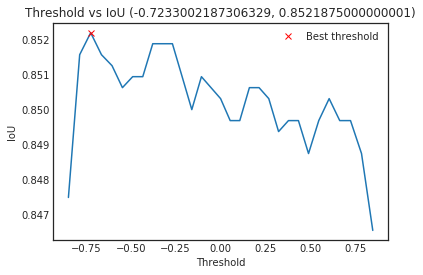

In [43]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [38]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [39]:
x_test = np.array([(np.array(load_img("TGS_salt/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/home/manmay_nakhashi/.local/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [40]:
preds_test = predict_result(model,x_test,img_size_target)

In [41]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()


In [42]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [34]:
t_finish = time.time()
print("Kernel run time = " + str((t_finish-t_start)/3600) + "hours")

Kernel run time = 4.523008776240879hours
